# Mutation Analyser tutorial

Welcome to the Mutation Analyser tutorial.
We will be using two sample files. The first one contains possible octamer sequences and their correspondent P and I indexes. You can download it here:

http://users.ictp.it/~dgrells/cssd2019/_downloads/4333ca883d3cba40b3336e2916d61f79/octamers.txt

The second one is a sample file with five genetic sequences for checking the final output of the code. You can download it here:

http://users.ictp.it/~dgrells/cssd2019/_downloads/01f89b67b4080f7e8d1cb64d115fa7a2/test.fasta

In [ ]:
path_name = # the path where the files are must be set here

Gathering the data from the files

In [ ]:
octamers_file = pd.read_csv(path_name + 'octamers.txt',
names = ['octamer', 'P', 'I'], sep = '\t', skiprows = 24, index_col = False)

with open(path_name + 'test.fasta') as file1:
    test_file = file1.readlines()

Importing the required packages

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.widgets import TextBox
from matplotlib.widgets import CheckButtons

The functions in this cell parse the strings in the files and adequately manage their data so that they can be plotted

In [12]:
# The functions in these cells
def return_indexes(octamers_db, sequence):
    '''
    returns the P and I indexes of the octamers a given nucleotide sequence, looping through the sequence
    and returning the indexes for each iterator

    Parameters
    ----------
    sequence : str

    Returns
    ----------
    out : lists
    '''
    assert(type(octamers_db)== type(pd.DataFrame()) ), "Input should be a DataFrame"
    p_list = []
    i_list = []
    for i in range(len(sequence)-8):
        seq_to_find = sequence[i:i+8].lower()
        p_index , i_index = find_values(seq_to_find, octamers_db)
        p_list.append(p_index)
        i_list.append(i_index)

    return(p_list, i_list)

def find_values(sequence, octamers_db):
#    print(octamers_db)
    P = np.float32(octamers_db[octamers_db['octamer']==sequence]['P'])
    I = np.float32(octamers_db[octamers_db['octamer']==sequence]['I'])
    return P, I

def setting_sequences(seq_list):
    '''
    sets the sequence in the test.fasta file in a correct way so they can be plotted correctly
    
    Parameters
    ----------
    seq_list : list of sequences from the test.fasta file
    
    Returns
    ----------
    out : lists, seq_names and seq_strings
    '''
    
    seq_dict = {}
    
    seq_names, seq_strings = [],[]
    for i,j in enumerate(seq_list):
        if '>' in j:
            seq_names.append(re.split('>|\n', j)[1])
        else:
            seq_strings.append(j[4:-6])

        
    for i,j in zip(seq_names, seq_strings):
        seq_dict[i] = j
    
    del seq_names, seq_strings
    return seq_dict


def update (sequence):
    octamers_dp = pd.read_csv('octamers.txt',
            names = ['octamer', 'P', 'I'], sep = '\t', skiprows = 24, index_col = False)
    p_values, i_values = return_indexes(octamers_dp, sequence)
    
    return p_values, i_values

The functions in the cell below set plotting parameters

In [13]:
plt.style.use('ggplot')

def plot_interactive(sequences_dict, genome_wt):
	keys = sequences_dict.keys()
	global fig
	fig, ax = plt.subplots(figsize=(20,4))
	print("Length of sequence is ", len(genome_wt))
	sequence1 = sequences_dict['wt']
	print("Length of values is ", len(sequence1))
	x_axis1 = range(len(sequence1))

	ax.fill_between(range(len(genome_wt)), -2.62, 2.62, color='y', alpha = 0.25)
	line1, = ax.plot(list(x_axis1), sequence1, label='wt')

	for i, protein in enumerate(genome_wt):
		ax.annotate(protein, (i,1), xycoords = ('data','axes points'))

	ax.set_xticklabels([])
	ax.set_ylim(-10,10)
	#ax.grid(False)
	ax.set_xlabel('Genome sequence')
	ax.set_ylabel('Index values')


	sequence2 = sequences_dict['M11x']
	x_axis2 = range(len(sequence2))
	line2, = ax.plot(list(x_axis2), sequence2, label='M11x')

	sequence3 = sequences_dict['M11']
	x_axis3 = range(len(sequence3))
	line3, = ax.plot(list(x_axis3), sequence3, label='M11')

	sequence4 = sequences_dict['M7']
	x_axis4 = range(len(sequence4))
	line4, = ax.plot(list(x_axis4), sequence4, label='M7')

	sequence5 = sequences_dict['M30']
	x_axis5 = range(len(sequence5))
	line5, = ax.plot(list(x_axis5), sequence4, label='M30')

	leg = ax.legend(loc='upper left', fancybox=True, shadow=True)
	leg.get_frame().set_alpha(0.4)

	# we will set up a dict mapping legend line to orig line, and enable
	# picking on the legend line
	lines = [line1, line2, line3, line4, line5]
	global lined

	lined = dict()

	for legline, origline in zip(leg.get_lines(), lines):
		legline.set_picker(5)  # 5 pts tolerance
		lined[legline] = origline

	fig.canvas.mpl_connect('pick_event', onpick)

	plt.show()

def onpick(event):
    	# on the pick event, find the orig line corresponding to the
    	# legend proxy line, and toggle the visibility
	legline = event.artist
	origline = lined[legline]
	vis = not origline.get_visible()
	origline.set_visible(vis)
	# Change the alpha on the line in the legend so we can see what lines
	# have been toggled
	if vis:
		legline.set_alpha(1.0)
	else:
		legline.set_alpha(0.2)
	fig.canvas.draw()


def get_plot_data(sequences, octamers_db):
	"""Gets all the aggregate data from the sequences
	Parameters:
		sequences = genome sequence in string format
		octamers_db = database of p-index and i-index values for each genome
	---------------------------
	Returns:
		Dictionary of aggregated data with key=Genome name, value= Genome sequence
	"""
	data_dict = dict()
	for key in sequences.keys():
		sequence = sequences[key]
		p_index, i_index = return_indexes(octamers_db, sequence)
		aggregate = aggregate_values(p_index, i_index)
		data_dict[key] = aggregate

	return data_dict


def plot(sequence_name, sequence, p_values, i_values):
	"""Saves a figure of P-index and I-index of a genome sequence)
	Parameters:
		sequence = genome sequence in string format
		p_values = pre-computed P-index of the sequence
		i_values = pre-computed I-index of the sequence
	---------------------------
	Returns:
		Saves a result.png figure in the current directory
	"""
	initial_text = sequence
	
	assert type(sequence)==type(str()), "Input sequence must be a string"
	assert(len(p_values) == len(i_values)), "P-index list must be of equal length to I-index list"
	assert(len(sequence) == len(p_values)+8), "Indexes length must be 8 less than sequence length"

	x_axis = range(len(sequence))

	#enhancers, silencers = analyze_values(p_values, i_values)

	####Plotting part
	fig, ax1 = plt.subplots(figsize=(20,4))
	#P-index and I-index plot
	#ax1.plot(list(x_axis[:-8]), p_values, c='b', label='P-index')
	#ax1.plot(list(x_axis[:-8]), i_values, c='m', label='I-index')
	ax1.fill_between(x_axis, -2.62, 2.62, color='y', alpha = 0.25)

	aggregate = aggregate_values(p_values, i_values)
	l0,= ax1.plot(list(x_axis[:-8]), aggregate, c='c', label=sequence_name)

	ax1.axvline(x=8, color='k')
	plt.subplots_adjust(left=0.25)
	rax=plt.axes([0.05, 0.4, 0.1, 0.15])
	check = CheckButtons(rax, [sequence_name], [True])
        

################ user input seq ################
	def submit(text):
		
		x,y= update(text)
		#l0,= ax1.plot(list(x_axis[:-8]), aggregate, c='c', label=sequence_name[1:])		
		l1,=ax1.plot(list(x_axis[:-8]), aggregate_values(x, y), label='Input seq.')

		plt.draw()
      

	axbox = plt.axes([0.15, 0.009, 0.8, 0.05])
	text_box = TextBox(axbox, 'Input seq.', initial=initial_text)
	text_box.on_submit(submit)

############## checkbox   #####################
	def func(label):
		if label == sequence_name[1:]:
			l0.set_visible(not l0.get_visible())	

		plt.draw()	
	check.on_clicked(func)

	
	#Plotting enchancer and silencer points
	for i in range(len(aggregate)):
		if aggregate[i] > 2.62:
			ax1.axvline(x=i, color='g', linestyle='--')
		elif aggregate[i]< -2.62:
			ax1.axvline(x=i, color='r', linestyle='--')
	#Annotating the sequence to figure
	for i, protein in enumerate(sequence):
		ax1.annotate(protein, (i,1), xycoords = ('data','axes points'))
	ax1.set_xticklabels([])

	#Axis labels
	ax1.set_ylim(-10,10)
	ax1.grid(False)
	ax1.set_xlabel('Genome sequence')
	ax1.set_ylabel('Index values')
	ax1.legend()
	fig.savefig('result.png', dpi=500)
	plt.show(fig)

def analyze_values(p_values, i_values):
	"""Creates a list of location of enhancers and silencers based
	on p_values and i_values of a sequence
	============================================
	Parameters:
		p_values: P-index values
		i_values: I-index values
	---------------------------------------------
	Returns:
		enhancers: list of enhancer location
		silencers: list of silencer location
	"""
	assert len(p_values)==len(i_values), "P-index must be of the same size as I-index"

	enhancers = []
	silencers = []
	for i in range(len(p_values)):
		if p_values[i] >2.62 and i_values[i]>2.62:
			enhancers.append(1)
			silencers.append(0)
		elif p_values[i]<-2.62 and i_values[i]<-2.62:
			silencers.append(1)
			enhancers.append(0)
		else:
			enhancers.append(0)
			silencers.append(0)

	return(enhancers, silencers)

def aggregate_values(p_values, i_values):
	"""Creates a list of aggregate values of p-index
	and i_index of a sequence
	============================================
	Parameters:
		p_values: P-index values
		i_values: I-index values
	---------------------------------------------
	Returns:
		aggregate: aggregated values 
	"""	
	aggregate = []
	for i in range(len(p_values)):
		if abs(p_values[i]) > abs(i_values[i]):
			aggregate.append(i_values[i])
		else:
			aggregate.append(p_values[i])

	return aggregate

Functions in the cell below plot the data

In [14]:
def comparative_plot(sequence_file, octamers_db):
	basis_genome = sequence_file['wt']
	sequence_dict = get_plot_data(sequence_file, octamers_db)
	plot_interactive(sequence_dict, basis_genome)

def interactive_plot(sequence_file, octamers_db):
	keys = sequence_file.keys()
	print('Choose sequence from this keys: ', list(keys))
	chosen_key = input(" ")

	chosen_sequence = sequence_file[chosen_key]
	print(chosen_sequence)

	p_values, i_values  = return_indexes(octamers_db,chosen_sequence)

	plot(chosen_key,chosen_sequence, p_values, i_values)

def main():
	sequence_file = setting_sequences(test_file)
	option = input("Which plot do you want to see?\n 1) Comparative Plot 2) Interactive plot \n")

	if option =='1':
		comparative_plot(sequence_file, octamers_file)
	elif option=='2':
		interactive_plot(sequence_file, octamers_file)

Which plot do you want to see?
 1) Comparative Plot 2) Interactive plot 
1
Length of sequence is  109
Length of values is  101


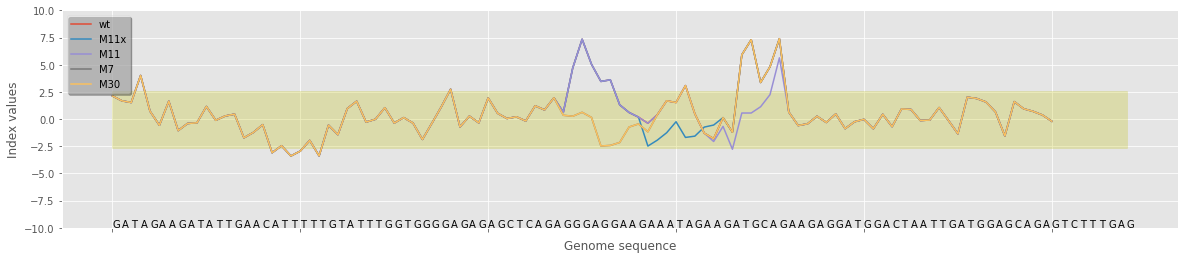

In [16]:
main()

Which plot do you want to see?
 1) Comparative Plot 2) Interactive plot 
2
Choose sequence from this keys:  ['wt', 'M30', 'M7', 'M11x', 'M11']
 wt
GATAGAAGATATTGAACATTTTTGTATTTGGTGGGGAGAGAGCTCAGAGGGAGGAAGAAATAGAAGATGCAGAAGAGGATGGACTAATTGATGGAGCAGAGTCTTTGAG


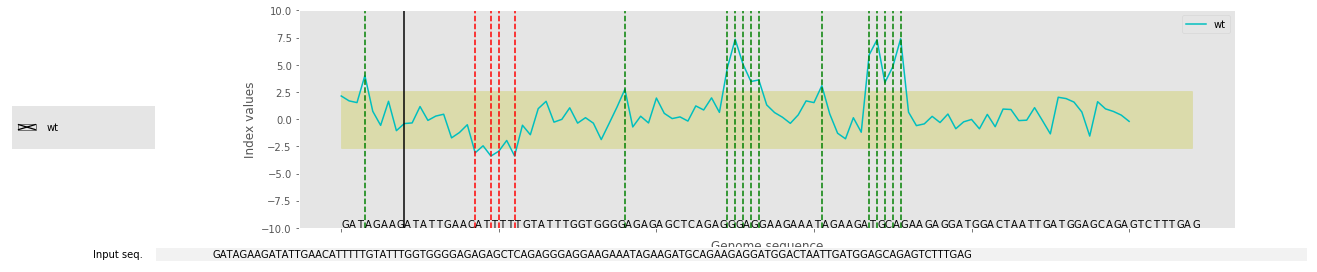

In [15]:
main()